In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [40]:
# load data
dt_train_raw = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
dt_test_raw = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [41]:
# outlier
dt_outlier = dt_train_raw.loc[dt_train_raw.y == max(dt_train_raw.y.values)]
dt_outlier

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,...,0,0,0,0,0,0,0,0,0,0


**X, y, ID**

In [42]:
# remove outlier
dt_train_raw_no_outlier = dt_train_raw.loc[dt_train_raw["ID"] != dt_outlier["ID"].values[0]]

In [43]:
X = dt_train_raw_no_outlier.drop(["ID", "y"], axis = 1)
y = dt_train_raw_no_outlier.y.values
ID = dt_train_raw_no_outlier.ID.values

In [44]:
X.shape

(4208, 376)

**One-hot Encoding**

In [45]:
# cols_cat
cols_cat = X.select_dtypes(include = ['object']).columns.values
dt_cat_onehot = pd.get_dummies(X[cols_cat])
X = X.drop(cols_cat, axis = 1)
X = X.join(dt_cat_onehot)

In [46]:
X.shape

(4208, 563)

**ExtraTree**

In [47]:
# extratree
params_extraTRee = {
    "n_jobs": 7
    , "n_estimators": 400
    , "max_depth": 3
    , "min_samples_split": 5
    , "random_state": 888
    , "verbose": 0
}
model_extra = ExtraTreesRegressor(**params_extraTRee)

**xgboost**

In [48]:
# params
params_xgb = {}
params_xgb['objective'] = 'reg:linear'
params_xgb['max_depth'] = 5
params_xgb['eta'] = 0.1
params_xgb['early_stopping_rounds'] = 10
params_xgb['silent'] = 0

num_boost_round = 500

In [49]:
# r^2
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    return 'score', r2_score(labels, preds)

**Random Split**

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 888)

In [51]:
# extraTree
model_extra.fit(X_train, y_train)
preds_valid = model_extra.predict(X_valid)
r2_score(y_valid, preds_valid)

0.55985569600611274

In [52]:
# xgboost
dtrain = xgb.DMatrix(X_train, label = y_train)
dtvalid = xgb.DMatrix(X_valid, label = y_valid)
ls_watch =  [(dtvalid, 'eval'), (dtrain, 'train')]
bst = xgb.train(params_xgb, dtrain
                , num_boost_round = num_boost_round, evals = ls_watch, early_stopping_rounds = 50
                , maximize = False, feval = r_2)

[0]	eval-rmse:91.2715	train-rmse:90.799	eval-score:-53.986	train-score:-52.1991
Multiple eval metrics have been passed: 'train-score' will be used for early stopping.

Will train until train-score hasn't improved in 50 rounds.
[1]	eval-rmse:82.2527	train-rmse:81.8063	eval-score:-43.6562	train-score:-42.1832
[2]	eval-rmse:74.1421	train-rmse:73.7195	eval-score:-35.2837	train-score:-34.0677
[3]	eval-rmse:66.8499	train-rmse:66.4492	eval-score:-28.4974	train-score:-27.4919
[4]	eval-rmse:60.2954	train-rmse:59.9147	eval-score:-22.9966	train-score:-22.1638
[5]	eval-rmse:54.4057	train-rmse:54.0437	eval-score:-18.5376	train-score:-17.8465
[6]	eval-rmse:49.1158	train-rmse:48.7709	eval-score:-14.923	train-score:-14.3484
[7]	eval-rmse:44.3666	train-rmse:44.0379	eval-score:-11.9925	train-score:-11.514
[8]	eval-rmse:40.1094	train-rmse:39.7922	eval-score:-9.61877	train-score:-9.21734
[9]	eval-rmse:36.2894	train-rmse:35.9865	eval-score:-7.69244	train-score:-7.35643
[10]	eval-rmse:32.8722	train-rmse:32.

**K Fold**

In [53]:
# stratified kfold
kf = KFold(n_splits = 5, shuffle = True, random_state = 888)

In [56]:
for ind_train, ind_valid in kf.split(X):
    # X, y
    X_train, X_valid = X.iloc[ind_train], X.iloc[ind_valid]
    y_train, y_valid = y[ind_train], y[ind_valid]
    
    # model_extra
    model_extra.fit(X_train, y_train) 
    preds_extra_train = model_extra.predict(X_train)
    preds_extra_valid = model_extra.predict(X_valid)
    score_extra_train = r2_score(y_train, preds_extra_train)
    score_extra_valid = r2_score(y_valid, preds_extra_valid)
    
    dtrain = xgb.DMatrix(X.iloc[ind_train], label = y[ind_train])
    dtvalid = xgb.DMatrix(X.iloc[ind_valid], label = y[ind_valid])
    ls_watch =  [(dtvalid, 'eval'), (dtrain, 'train')]

    bst = xgb.train(params_xgb, dtrain, num_boost_round = num_boost_round, evals = ls_watch, feval = r_2)

    res = bst.eval(dtvalid)
    
    print("EXtraTree R^2 on Train: ", score_train, "R^2 on Valid: ", res)

[0]	eval-rmse:91.2715	train-rmse:90.799	eval-score:-53.986	train-score:-52.1991
[1]	eval-rmse:82.2527	train-rmse:81.8063	eval-score:-43.6562	train-score:-42.1832
[2]	eval-rmse:74.1421	train-rmse:73.7195	eval-score:-35.2837	train-score:-34.0677
[3]	eval-rmse:66.8499	train-rmse:66.4492	eval-score:-28.4974	train-score:-27.4919
[4]	eval-rmse:60.2954	train-rmse:59.9147	eval-score:-22.9966	train-score:-22.1638
[5]	eval-rmse:54.4057	train-rmse:54.0437	eval-score:-18.5376	train-score:-17.8465
[6]	eval-rmse:49.1158	train-rmse:48.7709	eval-score:-14.923	train-score:-14.3484
[7]	eval-rmse:44.3666	train-rmse:44.0379	eval-score:-11.9925	train-score:-11.514
[8]	eval-rmse:40.1094	train-rmse:39.7922	eval-score:-9.61877	train-score:-9.21734
[9]	eval-rmse:36.2894	train-rmse:35.9865	eval-score:-7.69244	train-score:-7.35643
[10]	eval-rmse:32.8722	train-rmse:32.5781	eval-score:-6.13246	train-score:-5.84848
[11]	eval-rmse:29.8115	train-rmse:29.529	eval-score:-4.8661	train-score:-4.62652
[12]	eval-rmse:27.07

[100]	eval-rmse:7.97896	train-rmse:6.82781	eval-score:0.579782	train-score:0.699182
[101]	eval-rmse:7.97805	train-rmse:6.82588	eval-score:0.579878	train-score:0.699352
[102]	eval-rmse:7.98422	train-rmse:6.81431	eval-score:0.579228	train-score:0.70037
[103]	eval-rmse:7.98484	train-rmse:6.8037	eval-score:0.579163	train-score:0.701302
[104]	eval-rmse:7.98495	train-rmse:6.80008	eval-score:0.579151	train-score:0.70162
[105]	eval-rmse:7.9898	train-rmse:6.79604	eval-score:0.57864	train-score:0.701975
[106]	eval-rmse:7.99389	train-rmse:6.78705	eval-score:0.578209	train-score:0.702763
[107]	eval-rmse:7.99515	train-rmse:6.78266	eval-score:0.578075	train-score:0.703147
[108]	eval-rmse:7.99611	train-rmse:6.7795	eval-score:0.577974	train-score:0.703423
[109]	eval-rmse:7.99624	train-rmse:6.77727	eval-score:0.57796	train-score:0.703618
[110]	eval-rmse:7.9981	train-rmse:6.76622	eval-score:0.577763	train-score:0.704584
[111]	eval-rmse:7.99916	train-rmse:6.76167	eval-score:0.577652	train-score:0.704981


[199]	eval-rmse:8.11848	train-rmse:6.10182	eval-score:0.564958	train-score:0.759752
[200]	eval-rmse:8.11975	train-rmse:6.09706	eval-score:0.564822	train-score:0.760126
[201]	eval-rmse:8.12576	train-rmse:6.09082	eval-score:0.564177	train-score:0.760617
[202]	eval-rmse:8.12452	train-rmse:6.06996	eval-score:0.56431	train-score:0.762254
[203]	eval-rmse:8.12591	train-rmse:6.06821	eval-score:0.564162	train-score:0.762391
[204]	eval-rmse:8.12397	train-rmse:6.06294	eval-score:0.564369	train-score:0.762804
[205]	eval-rmse:8.12441	train-rmse:6.06208	eval-score:0.564323	train-score:0.762871
[206]	eval-rmse:8.12511	train-rmse:6.05978	eval-score:0.564247	train-score:0.76305
[207]	eval-rmse:8.12362	train-rmse:6.0516	eval-score:0.564407	train-score:0.76369
[208]	eval-rmse:8.12258	train-rmse:6.04684	eval-score:0.564519	train-score:0.764061
[209]	eval-rmse:8.1229	train-rmse:6.0351	eval-score:0.564484	train-score:0.764977
[210]	eval-rmse:8.12338	train-rmse:6.0305	eval-score:0.564432	train-score:0.765335

[298]	eval-rmse:8.28456	train-rmse:5.49922	eval-score:0.546977	train-score:0.804861
[299]	eval-rmse:8.28445	train-rmse:5.49103	eval-score:0.546988	train-score:0.805442
[300]	eval-rmse:8.28883	train-rmse:5.48013	eval-score:0.546509	train-score:0.806214
[301]	eval-rmse:8.29623	train-rmse:5.46875	eval-score:0.545699	train-score:0.807018
[302]	eval-rmse:8.30224	train-rmse:5.46418	eval-score:0.545041	train-score:0.80734
[303]	eval-rmse:8.30301	train-rmse:5.46245	eval-score:0.544956	train-score:0.807462
[304]	eval-rmse:8.30516	train-rmse:5.45607	eval-score:0.544721	train-score:0.807911
[305]	eval-rmse:8.30466	train-rmse:5.45443	eval-score:0.544776	train-score:0.808027
[306]	eval-rmse:8.3075	train-rmse:5.44631	eval-score:0.544464	train-score:0.808598
[307]	eval-rmse:8.31356	train-rmse:5.4388	eval-score:0.543799	train-score:0.809126
[308]	eval-rmse:8.31383	train-rmse:5.43773	eval-score:0.54377	train-score:0.809201
[309]	eval-rmse:8.31458	train-rmse:5.43607	eval-score:0.543687	train-score:0.809

[397]	eval-rmse:8.39249	train-rmse:5.07446	eval-score:0.535095	train-score:0.833842
[398]	eval-rmse:8.39179	train-rmse:5.07394	eval-score:0.535173	train-score:0.833876
[399]	eval-rmse:8.39193	train-rmse:5.07146	eval-score:0.535158	train-score:0.834038
[400]	eval-rmse:8.39086	train-rmse:5.06913	eval-score:0.535277	train-score:0.834191
[401]	eval-rmse:8.39196	train-rmse:5.06603	eval-score:0.535154	train-score:0.834393
[402]	eval-rmse:8.39202	train-rmse:5.05729	eval-score:0.535148	train-score:0.834964
[403]	eval-rmse:8.39252	train-rmse:5.05641	eval-score:0.535092	train-score:0.835022
[404]	eval-rmse:8.39256	train-rmse:5.05	eval-score:0.535088	train-score:0.83544
[405]	eval-rmse:8.39404	train-rmse:5.03903	eval-score:0.534924	train-score:0.836154
[406]	eval-rmse:8.39387	train-rmse:5.03767	eval-score:0.534943	train-score:0.836242
[407]	eval-rmse:8.39402	train-rmse:5.03424	eval-score:0.534926	train-score:0.836466
[408]	eval-rmse:8.39442	train-rmse:5.02911	eval-score:0.534881	train-score:0.836

[495]	eval-rmse:8.48095	train-rmse:4.69949	eval-score:0.525243	train-score:0.857491
[496]	eval-rmse:8.48168	train-rmse:4.69799	eval-score:0.525162	train-score:0.857582
[497]	eval-rmse:8.48283	train-rmse:4.69182	eval-score:0.525032	train-score:0.857956
[498]	eval-rmse:8.48247	train-rmse:4.68926	eval-score:0.525073	train-score:0.858111
[499]	eval-rmse:8.48297	train-rmse:4.68543	eval-score:0.525017	train-score:0.858342


NameError: name 'score_train' is not defined

**Stratified Kfold**

In [66]:
bin_y = pd.qcut(y, 5, labels = [1, 2, 3, 4, 5]).astype("int64")

In [67]:
unique, counts = np.unique(np.array(bin_y), return_counts = True)
print(np.asarray((unique, counts)).T)

[[  1 844]
 [  2 839]
 [  3 843]
 [  4 841]
 [  5 841]]


In [68]:
# stratified kfold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 888)

In [69]:
for ind_train, ind_valid in skf.split(X, y):
    # X, y
    X_train, X_valid = X.iloc[ind_train], X.iloc[ind_valid]
    y_train, y_valid = y[ind_train], y[ind_valid]
    
    print("X_train: ", X_train.shape, "X_valid: ", X_valid.shape)
    # model
    model_extra.fit(X_train, y_train)
    # pred
    preds_valid = model_extra.predict(X_valid)
    # score
    score = r2_score(y_valid, preds_valid)
    print("R^2: ", score)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


X_train:  (3373, 563) X_valid:  (835, 563)
R^2:  0.548787029629
X_train:  (3349, 563) X_valid:  (859, 563)
R^2:  0.55693412362
X_train:  (3371, 563) X_valid:  (837, 563)
R^2:  0.632734646342
X_train:  (3401, 563) X_valid:  (807, 563)
R^2:  0.580648822685
X_train:  (3338, 563) X_valid:  (870, 563)
R^2:  0.605040579878


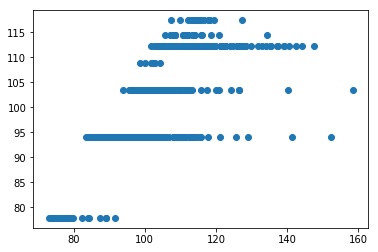

In [70]:
plt.scatter(y_valid, preds_valid)
plt.show()

In [ ]:
# group kfold